In [1]:
import os
import glob
dataset_dir = "/kaggle/input/lungss/lungs/archive/MontgomerySet"

# Correct the pattern for finding images
cxr_paths = glob.glob(os.path.join(dataset_dir, 'CXR_png', '*.png'))

# Check if cxr_paths is empty
if not cxr_paths:
    print("No CXR images found. Please check the dataset directory and file paths.")
else:
    cxr_images = []

    for c_path in cxr_paths:
        left_mask = os.path.join(dataset_dir, 'ManualMask', 'leftMask', os.path.basename(c_path))
        right_mask = os.path.join(dataset_dir, 'ManualMask', 'rightMask', os.path.basename(c_path))

        if os.path.exists(left_mask) and os.path.exists(right_mask):
            cxr_images.append((c_path, [left_mask, right_mask]))

    print('Total CXR Images:', len(cxr_paths))
    print('Total Valid Images with Masks:', len(cxr_images))
    print('Example Image Path:', cxr_paths[0])
    print('Example Image with Masks:', cxr_images[0])

Total CXR Images: 138
Total Valid Images with Masks: 138
Example Image Path: /kaggle/input/lungss/lungs/archive/MontgomerySet/CXR_png/MCUCXR_0017_0.png
Example Image with Masks: ('/kaggle/input/lungss/lungs/archive/MontgomerySet/CXR_png/MCUCXR_0017_0.png', ['/kaggle/input/lungss/lungs/archive/MontgomerySet/ManualMask/leftMask/MCUCXR_0017_0.png', '/kaggle/input/lungss/lungs/archive/MontgomerySet/ManualMask/rightMask/MCUCXR_0017_0.png'])


In [2]:
import cv2
import numpy as np
from skimage.transform import resize
from tqdm import tqdm

#set dimensions for all images
OUT_DIM = (256, 256)

def process_cxr_image(in_path):
    #reads a CXR image, resizes it, and applies CLAHE for contrast enhancement.
    #clahe takes tiles and applies histogram equalization to it
    #grayscale
    
    img_data = cv2.imread(in_path, cv2.IMREAD_GRAYSCALE)
    if img_data is None:
        raise ValueError(f"Error reading image: {in_path}")

    #interpolation is for resizing, and INTER_AREA downscales by averaging
    img_resized = cv2.resize(img_data, OUT_DIM, interpolation=cv2.INTER_AREA)

    #divide to tiles, applies hist equalization to each of them
    clahe_tool = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  
    img_clahe = clahe_tool.apply(img_resized)

    #convert to float32 for better model input; makes it between 0-1
    img_clahe = img_clahe.astype(np.float32) / 255.0

    return np.expand_dims(img_clahe, -1)  #adding a dimension, to keep it grayscaled
                                          # (H, W) → (H, W, 1)

In [3]:
def process_segmentation_mask(mask_paths):
    #reads, resizes, and merges left & right lung segmentation masks.
    #ensures binary segmentation (values 0 or 1).
    mask_list = []

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #read as grayscale
        if mask is None:
            raise ValueError(f"Error reading mask: {mask_path}")

        #INTER_NEAREST is used for binary, to estimate pixel values while resizing/scaling
        mask = cv2.resize(mask, OUT_DIM, interpolation=cv2.INTER_NEAREST)

        #normalize mask to binary values (0 or 1)
        mask = (mask > 0).astype(np.float32)

        mask_list.append(mask)

    #merge
    mask_combined = np.max(np.stack(mask_list, axis=0), axis=0)  # OR operation
    return np.expand_dims(mask_combined, -1)  # (H, W) → (H, W, 1)

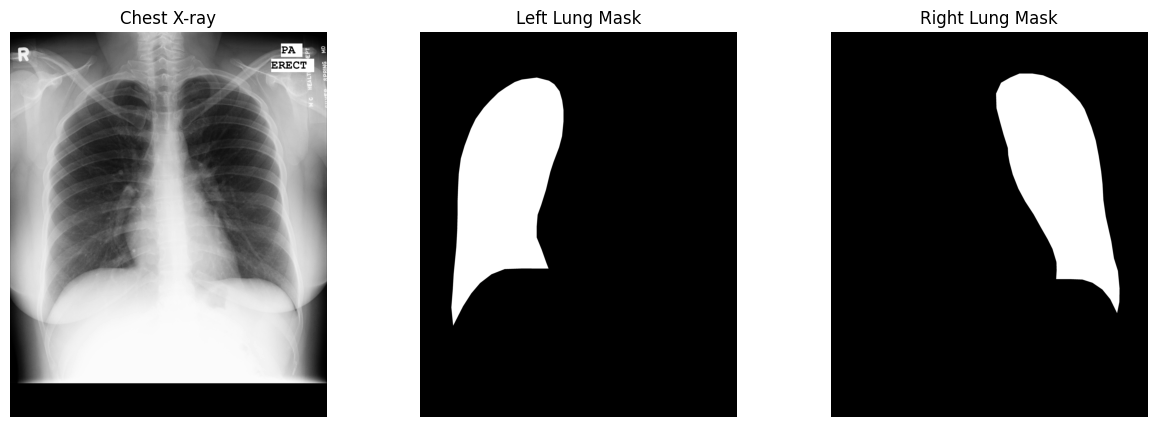

In [5]:
import matplotlib.pyplot as plt

cxr_img_path, mask_paths = cxr_images[5]

# Load the images
cxr_img = cv2.imread(cxr_img_path, cv2.IMREAD_GRAYSCALE)  # Load X-ray
left_mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)  # Load left mask
right_mask = cv2.imread(mask_paths[1], cv2.IMREAD_GRAYSCALE)  # Load right mask

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cxr_img, cmap='gray')
axes[0].set_title('Chest X-ray')

axes[1].imshow(left_mask, cmap='gray')
axes[1].set_title('Left Lung Mask')

axes[2].imshow(right_mask, cmap='gray')
axes[2].set_title('Right Lung Mask')

for ax in axes:
    ax.axis('off')

plt.show()

In [6]:
img_vol, seg_vol = [], []

for img_path, s_paths in tqdm(cxr_images, desc="Processing CXR & Masks"):
    img_vol.append(process_cxr_image(img_path))  #process CXR image
    seg_vol.append(process_segmentation_mask(s_paths))  #process segmentation masks

#convert lists to NumPy arrays
img_vol = np.stack(img_vol, axis=0)
seg_vol = np.stack(seg_vol, axis=0)

#print dataset shapes
print('Images:', img_vol.shape, '| Segmentations:', seg_vol.shape)

Processing CXR & Masks: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s]

Images: (138, 256, 256, 1) | Segmentations: (138, 256, 256, 1)


In [7]:
import numpy as np
import tensorflow as tf

def augment(image, mask):
    #applies data augmentation to the image and mask.

    # Random horizontal flips
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random rotations (up to 10 degrees)
    angle = tf.random.uniform((), minval=-10, maxval=10)
    image = tf.keras.preprocessing.image.random_rotation(
        image, angle, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest'
    )
    mask = tf.keras.preprocessing.image.random_rotation(
        mask, angle, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest'
    )

    # Random brightness adjustments
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.clip_by_value(image, 0.0, 1.0)  # Ensure values are within [0, 1]

    return image, mask

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(img_vol, seg_vol, test_size=0.3, random_state=42) #70-15-15
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#batching
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) #let tensorflow decide best amount

print("Train dataset batches:", len(train_dataset))
print("Validation dataset batches:", len(val_dataset))
print("Test dataset batches:", len(test_dataset))
print("Train dataset element shapes:", train_dataset.element_spec)

Train dataset batches: 3
Validation dataset batches: 1
Test dataset batches: 1
Train dataset element shapes: (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    #First: upsampled conv5 result, Second: conv4 (from encoder block 4, before it was downsampled)
    #This is the skip connection. | axis=3 for channel  
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    #the skip connection takes features from encoder block and maps it directly to the
    #decoder block present at same level
    #next, it again refines the image by conv2d
    #without it, it won't give refined results

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) 
    #sigmoid for 1/0
    #relu is for linearity, makes negative values 0

    return Model(inputs=[inputs], outputs=[conv10])

In [10]:
def dice_coef(y_true, y_pred, smooth=1): #stability to avoid divide by 0
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1) #pixelwise abs product for the last channel
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [11]:
model = unet()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef, 'binary_accuracy'])

model.summary()
#Dice Coefficient is a specialized metric for segmentation tasks. It evaluates the overlap between the true foreground and predicted foreground, dice loss derived from here
#Binary Accuracy, on the other hand, measures how often the model's predictions match the true labels,

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50, 
    verbose=1
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step - binary_accuracy: 0.2755 - dice_coef: 0.8146 - loss: 0.1854 - val_binary_accuracy: 0.4171 - val_dice_coef: 0.8183 - val_loss: 0.1817
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 751ms/step - binary_accuracy: 0.4305 - dice_coef: 0.8175 - loss: 0.1825 - val_binary_accuracy: 0.4289 - val_dice_coef: 0.8207 - val_loss: 0.1793
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 749ms/step - binary_accuracy: 0.4286 - dice_coef: 0.8199 - loss: 0.1801 - val_binary_accuracy: 0.4130 - val_dice_coef: 0.8228 - val_loss: 0.1772
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 758ms/step - binary_accuracy: 0.4698 - dice_coef: 0.8219 - loss: 0.1781 - val_binary_accuracy: 0.7168 - val_dice_coef: 0.8247 - val_loss: 0.1753
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step - binary_accuracy: 0.7357 - dice_coef: 0.8238 - loss: 0.1762 - val_binary_accuracy: 0.7321 - val_dice_coef: 0.8264 - val_loss: 0.1736
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 756ms/step - binary_accuracy: 0.7473 - dic

In [14]:
test_loss, test_dice, test_accuracy = model.evaluate(test_dataset)

test_dice_percent = test_dice * 100
test_accuracy_percent = test_accuracy * 100

print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice_percent:.2f}%, Test Accuracy: {test_accuracy_percent:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - binary_accuracy: 0.9350 - dice_coef: 0.9744 - loss: 0.0256
Test Loss: 0.0256, Test Dice: 97.44%, Test Accuracy: 93.50%


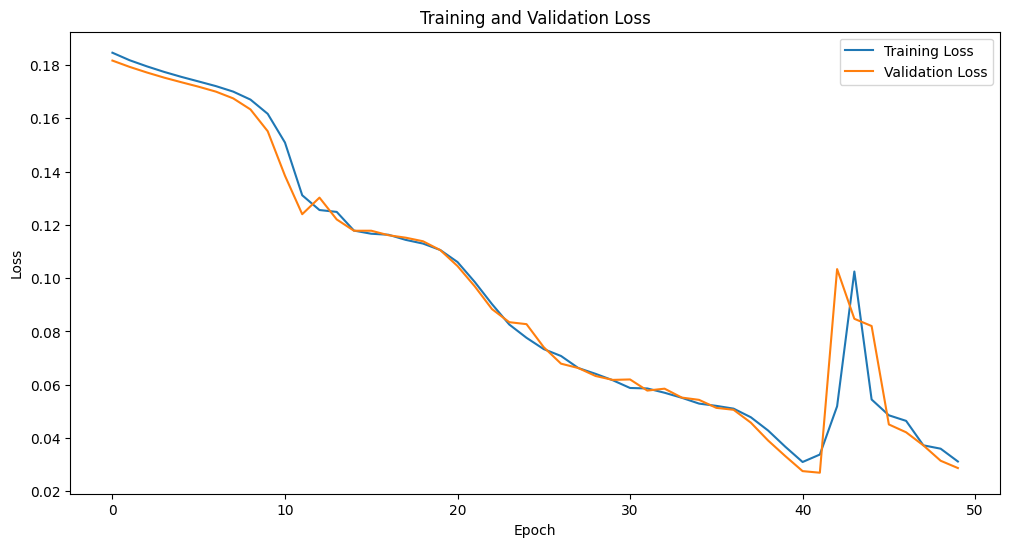

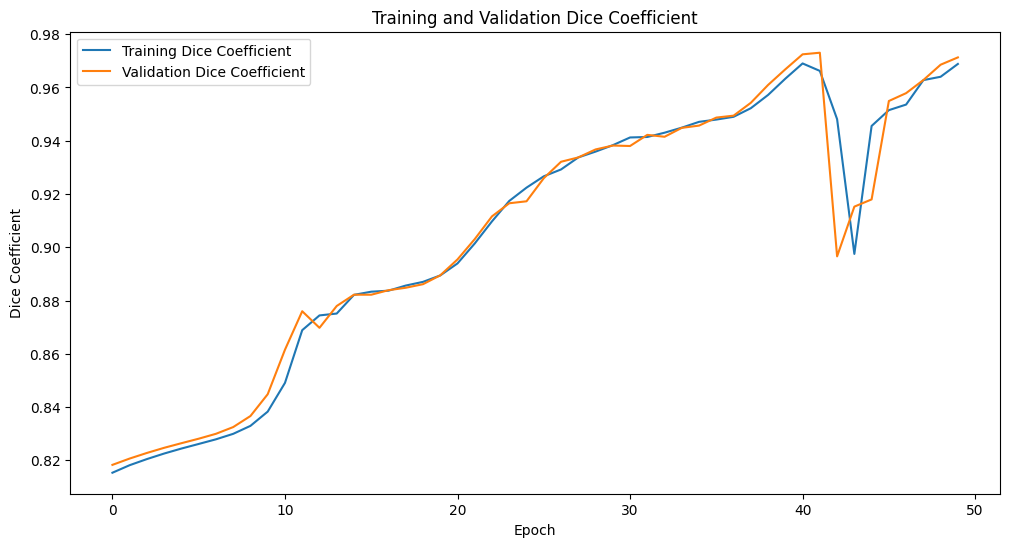

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image 8 - Predicted mask min: 0.0
Image 8 - Predicted mask max: 0.99595165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image 19 - Predicted mask min: 0.0
Image 19 - Predicted mask max: 0.99727327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 13 - Predicted mask min: 0.0
Image 13 - Predicted mask max: 0.99474853


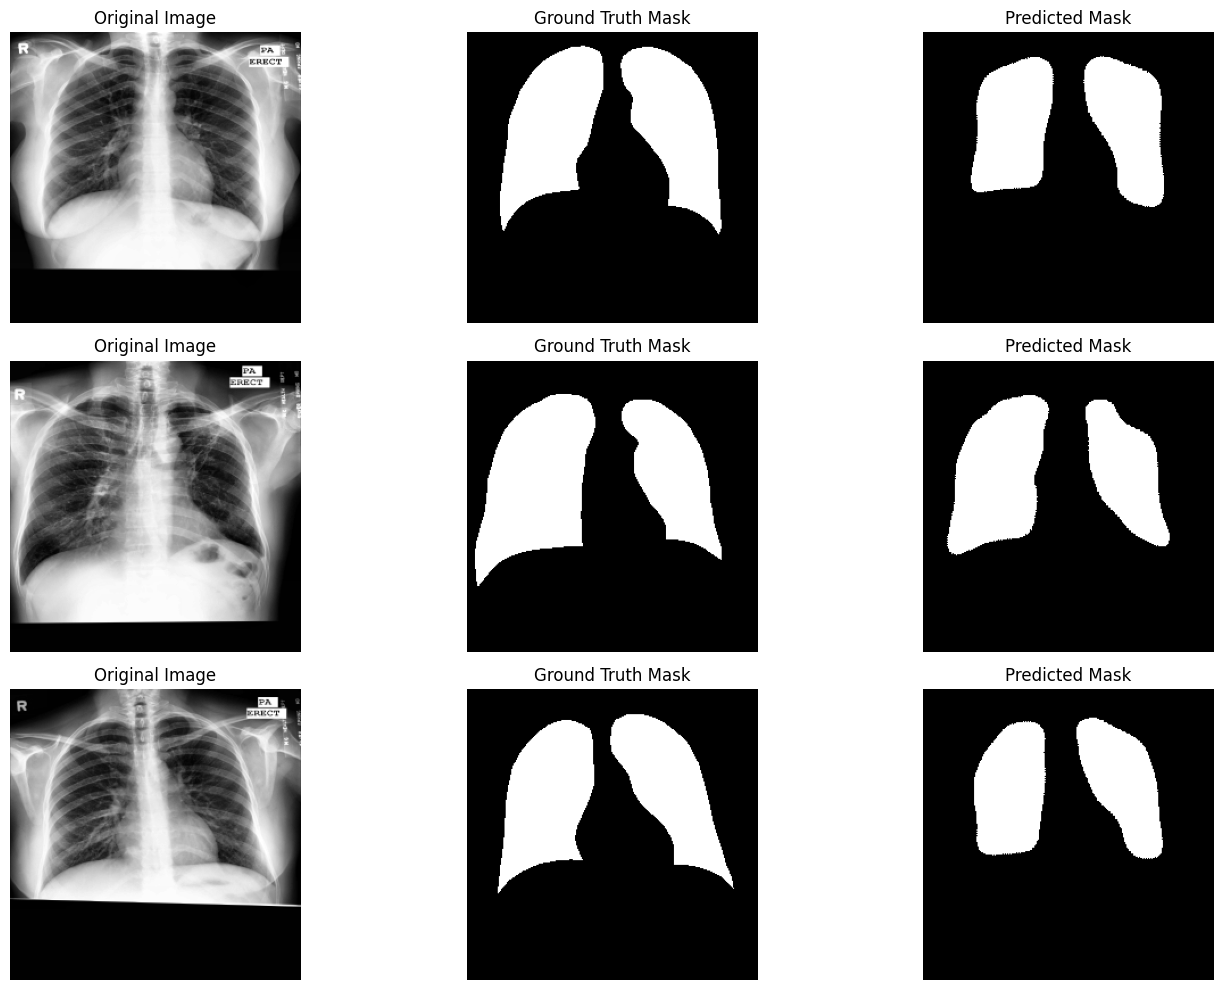

In [16]:
import random
test_data = list(test_dataset.unbatch().as_numpy_iterator())

# Choose 3 random indices
random_indices = random.sample(range(len(test_data)), 3)

# Plot the images, predicted masks, and ground truth masks
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    image, mask = test_data[index]

    # Make prediction
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

    # --- ADDED DEBUGGING SECTION ---
    # Print the minimum and maximum values of the predicted mask
    print(f"Image {index} - Predicted mask min:", np.min(predicted_mask))
    print(f"Image {index} - Predicted mask max:", np.max(predicted_mask))

    # Threshold the predicted mask
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.float32)
    # --- END ADDED DEBUGGING SECTION ---

    # Plot original image
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

Otsu Threshold (Gabor Lines): 11


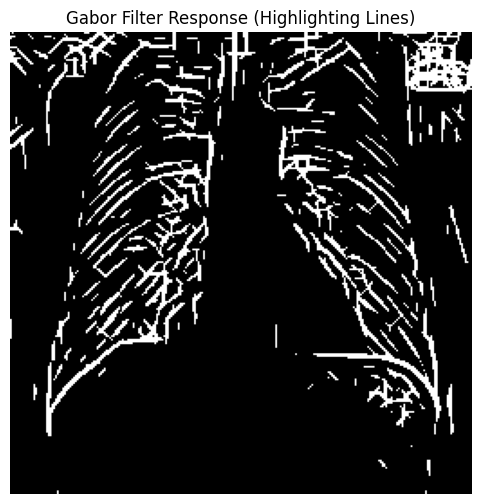

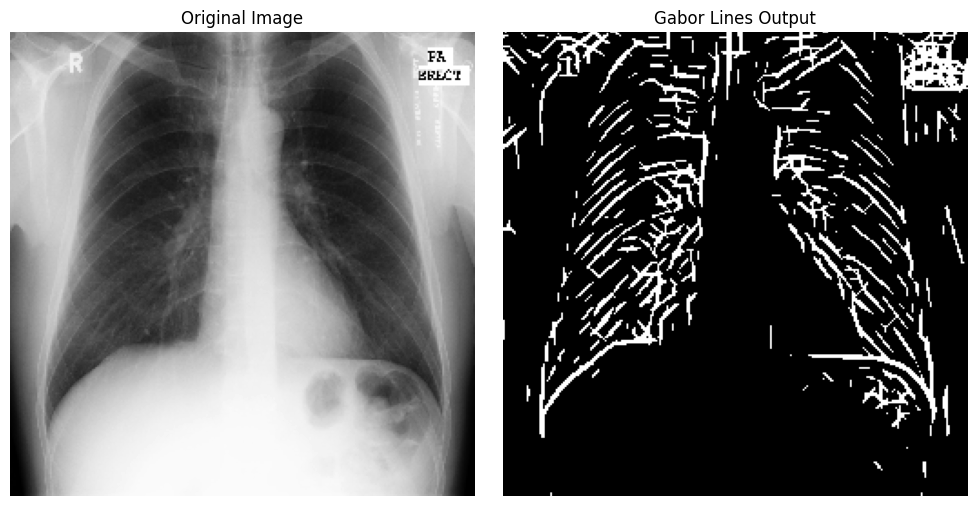

Otsu Threshold (Gabor Lines): 26


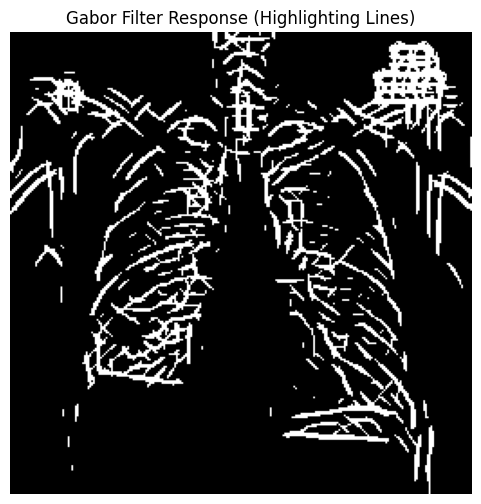

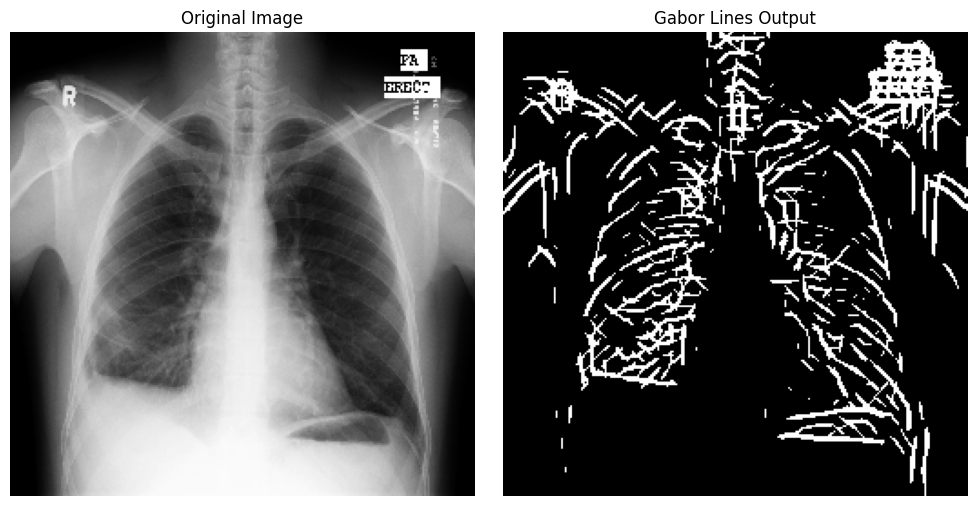

Otsu Threshold (Gabor Lines): 23


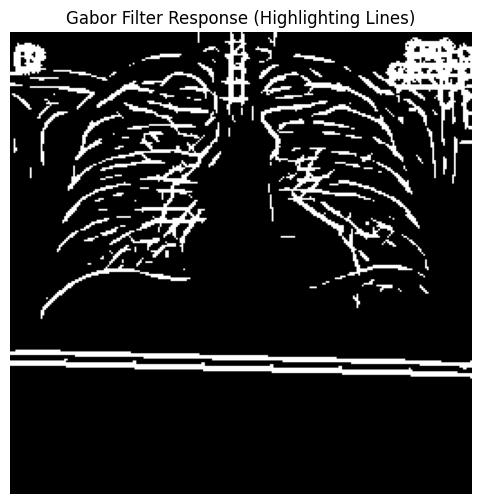

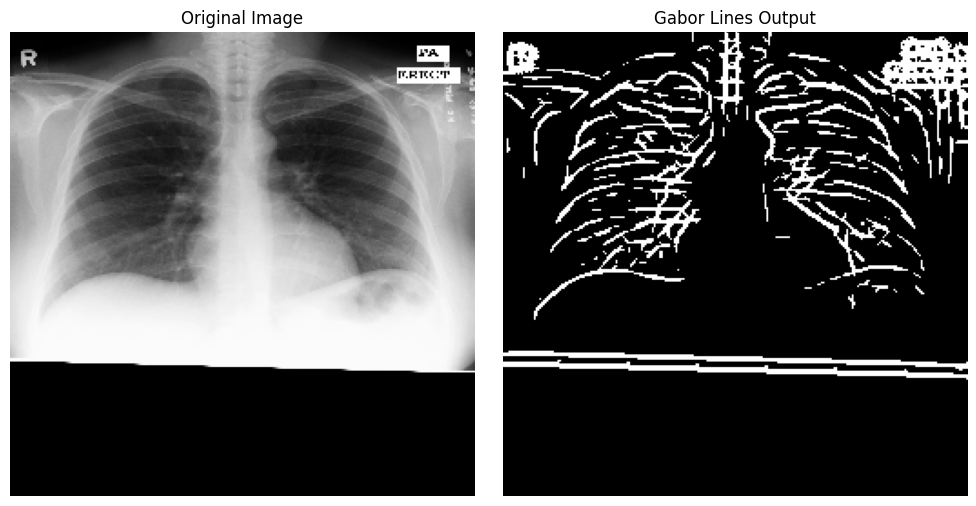

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gabor
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, remove_small_objects, ball
from skimage.measure import label, regionprops

def apply_clahe(img, clip_limit=2.0, grid_size=(8, 8)):
    """Applies Contrast Limited Adaptive Histogram Equalization."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply(img)

def apply_gabor_filter(img, frequency=0.2, orientation=0): # Adjusted frequency
    """Applies a single Gabor filter."""
    filt_real, _ = gabor(img, frequency=frequency, theta=orientation)
    return filt_real

def segment_lungs_classic_gabor_lines(image_path):
    """Segments lungs using Gabor filter to highlight lines and stops there."""
    try:
        # 1. Preprocessing
        img_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img_original is None:
            print(f"Error: Could not read image at {image_path}")
            return None

        img_resized = cv2.resize(img_original, (256, 256))
        img_clahe = apply_clahe(img_resized)
        img_blurred = cv2.GaussianBlur(img_clahe, (5, 5), 0)

        # 2. Gabor-based (multiple orientations)
        gabor_responses = []
        for orientation in [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]:
            gabor_response = apply_gabor_filter(img_blurred, frequency=0.2, orientation=orientation) # Adjusted frequency
            gabor_responses.append(np.abs(gabor_response))

        # Combine responses by taking the maximum
        abs_gabor_response_combined = np.max(np.array(gabor_responses), axis=0)

        thresh_gabor = threshold_otsu(abs_gabor_response_combined)
        mask_gabor_lines = (abs_gabor_response_combined > thresh_gabor).astype(np.uint8) * 255 # Keep as 0-255 for visualization

        print(f"Otsu Threshold (Gabor Lines): {thresh_gabor}")
        plt.figure(figsize=(6, 6))
        plt.imshow(mask_gabor_lines, cmap='gray')
        plt.title("Gabor Filter Response (Highlighting Lines)")
        plt.axis('off')
        plt.show()

        return img_resized, mask_gabor_lines

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

if __name__ == "__main__":
    import os
    import random

    dataset_dir = "/kaggle/input/lungss/lungs/archive/MontgomerySet"  # Adjust this path
    cxr_dir = os.path.join(dataset_dir, 'CXR_png')
    image_paths = [os.path.join(cxr_dir, fname) for fname in os.listdir(cxr_dir) if fname.endswith('.png')]

    if not image_paths:
        print(f"No PNG images found in {cxr_dir}. Please check the dataset path.")
    else:
        random_images = random.sample(image_paths, min(3, len(image_paths)))  # Process up to 5 random images

        for img_path in random_images:
            original_img, gabor_lines_mask = segment_lungs_classic_gabor_lines(img_path)

            if original_img is not None:
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.imshow(original_img, cmap='gray')
                plt.title("Original Image")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(gabor_lines_mask, cmap='gray')
                plt.title("Gabor Lines Output")
                plt.axis('off')

                plt.tight_layout()
                plt.show()